## Entrega Práctica NLP - Entrenamiento, Test y Métricas - Luis Martín Vegas ##

Cargamos las librerias que necesitaremos.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np
import random

Cargamos el dataset con las reviews ya procesadas.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df = pd.read_csv("drive/MyDrive/Datasets/cleaned_cellphones.csv")
df.head()

,cleaned_review,overall
0,look good stick good like rounded shape always...,4
1,sticker work like review say stick great stay ...,5
2,awesome make phone look stylish used one far a...,5
3,item arrived great time perfect condition howe...,4
4,awesome stay look great used multiple apple pr...,5


Generamos una variable de sentimiento de acuerdo con la valoración de la review.

In [7]:
df.loc[:, 'sentiment'] = [0 if rank <= 3 else 1 for rank in df['overall']]
df = df[df['cleaned_review'] != ''].sample(2000).reset_index(drop=True)
df.head()

,cleaned_review,overall,sentiment
0,pro seems like nicely made product compact suc...,3,0
1,nt120t outstanding battery pack sleek function...,5,1
2,bought headset want hassle wired headset price...,5,1
3,heard flip drive ue miniboom oontz wound picki...,4,1
4,going though different brand style etc headset...,3,0


Separamos el dataset en training y test set. En este caso no utilizaremos validation set para optimizar los hiperparámetros del modelo. Realizaremos la evaluación directamente con el test set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'],
    df['sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=df['sentiment']
)

Extraemos las features del texto de nuestras reviews utilizando TFIDF.

In [9]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)

cv

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, strip_accents='ascii')

Ejemplos de los TF-IDF scores del training set y test set.

In [10]:
cv.fit(X_train.values.astype('U'))
print(list(cv.vocabulary_.items())[:20])
print(len(cv.vocabulary_))
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

[('making', 832), ('stylus', 1407), ('also', 51), ('function', 565), ('pen', 1007), ('great', 604), ('idea', 672), ('carry', 210), ('pocket', 1047), ('look', 807), ('one', 952), ('would', 1628), ('like', 785), ('make', 831), ('able', 10), ('fit', 525), ('end', 447), ('writing', 1632), ('concerned', 287), ('losing', 812)]
1640


Entrenamos un modelo con distintos hiperparámetros a fin de optimizarlos evaluando la accuracy.

In [11]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.762
Accuracy for C=0.05: 0.762
Accuracy for C=0.25: 0.762
Accuracy for C=0.5: 0.764
Accuracy for C=1: 0.784
Accuracy for C=10: 0.806
Accuracy for C=100: 0.78
Accuracy for C=1000: 0.756
Accuracy for C=10000: 0.752


La Accuracy del modelo mejora considerablemente para C=10.
Lo visualizamos para train y para test set.

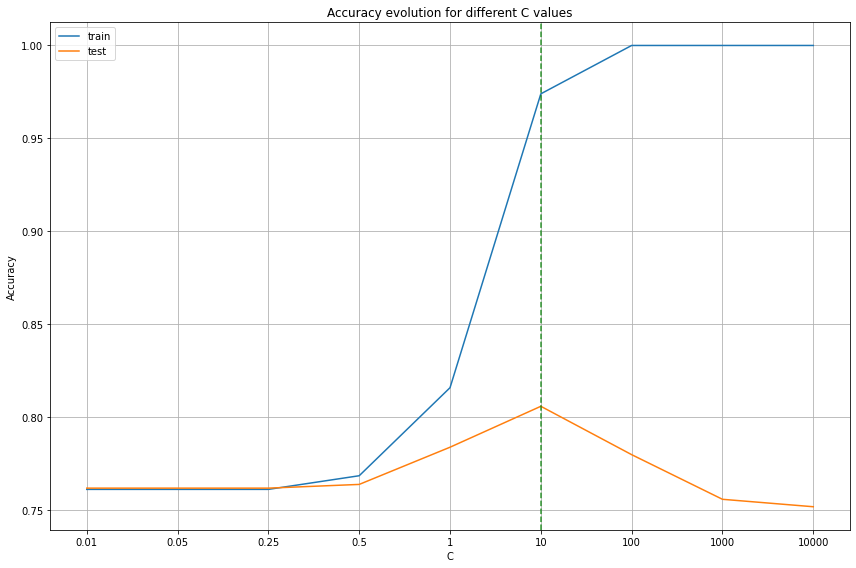

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Si bien los resultados son peores para test, podemos observar que para ambos C=10 da los resultados óptimos.

In [13]:
lr = LogisticRegression(C=10, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)
lr_train_predict = lr.predict(X_train_)
lr_test_predict = lr.predict(X_test_)
pickle.dump(lr, open('../content/lr.pkl', 'wb'))

In [14]:
def print_model_metrics(y_test, y_test_predict):
    print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_test_predict)))
    print('\nClassification report:\n{}'.format(classification_report(y_test, y_test_predict)))
    print('Accuracy score:{}'.format(accuracy_score(y_test, y_test_predict)))

In [15]:
print_model_metrics(y_test, lr_test_predict)

Confussion matrix:
[[ 45  74]
 [ 23 358]]

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.38      0.48       119
           1       0.83      0.94      0.88       381

    accuracy                           0.81       500
   macro avg       0.75      0.66      0.68       500
weighted avg       0.79      0.81      0.79       500

Accuracy score:0.806


Probamos a entrenar otro tipo de modelo para comparar los resultados obtenidos. En este caso, entrenaremos un modelo de Multinomial Naive Bayes.

In [16]:
mnb = MultinomialNB()
mnb.fit(X_train_, y_train)
mnb_train_predict = mnb.predict(X_train_)
mnb_test_predict = mnb.predict(X_test_)
mnb_test_predict_accuracy = accuracy_score(y_test, mnb_test_predict)
mnb_test_predict_accuracy

0.766

In [17]:
pickle.dump(mnb, open('../content/mnb.pkl', 'wb'))

In [18]:
print_model_metrics(y_test, mnb_test_predict)

Confussion matrix:
[[  2 117]
 [  0 381]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       119
           1       0.77      1.00      0.87       381

    accuracy                           0.77       500
   macro avg       0.88      0.51      0.45       500
weighted avg       0.82      0.77      0.67       500

Accuracy score:0.766


Los resultados son mejores para la Regresión Logística, presentando una mayor accuracy.

Definimos una función que nos permita comprobar, para algunos ejemplos de reviews, el sentimiento real frente el predicho.

In [19]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index,2]))
    r = df.iloc[review_index,0]
    print('Prediction with lr: {}'.format(lr.predict(cv.transform([r]))))
    print('Prediction with mnb: {}'.format(mnb.predict(cv.transform([r]))))

In [20]:
for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 260
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 201
Actual sentiment: 0
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 1276
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 1010
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 1943
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 1072
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 1301
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 911
Actual sentiment: 0
Prediction with lr: [0]
Prediction with mnb: [1]

Review no. 631
Actual sentiment: 1
Prediction with lr: [1]
Prediction with mnb: [1]

Review no. 370
Actual sentiment: 0
Prediction with lr: [0]
Prediction with mnb: [0]


Comprobamos cómo el modelo de Regresión Logística si que ha acertado en todos los supuestos mientras que el modelo de Multinomial Naive Bayes para algunas observaciones. 